# Decision Tree

In [1]:
## Author : Nikhil Tarte
## Contact: nikhilttarte@gmail.com

## Date: 13 March 2017

## 
#  Implementation of Decision Tree
#  Implement it on iris Dataset
##

Imports

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mode

Dataset Import

In [3]:
from sklearn.datasets import load_iris

Decision Node Class

In [4]:
class DecisionNode:
    def __init__(self, attributeName, attributeColNum,conditionThreshod):
        self.attributeName = attributeName
        self.attributeColNum = attributeColNum
        self.conditionThreshod = conditionThreshod
        self.leftNode = None
        self.rightNode = None
        self.className = None
        self.classified_in = -1

Dataset Format as Needed

In [5]:
#To Append Source and Target in One DataFrame with some additional Arrribures
#Retrun :: dataset, numRows,numCols, targetColNum, attribureNames, classNames
#Node: Dataset may not have Features names Col, to be adjusted as per Dataset
def styleDataset(sourceDataset):
    resultDataset = []
    dataframe = pd.DataFrame(sourceDataset.data)
    m,n = dataframe.shape
    for i in range(n):
        resultDataset.append(dataframe[i])
    resultDataset.append(pd.DataFrame(sourceDataset.target)[0])
        
    resultDataset = pd.DataFrame(np.array(resultDataset).T)
    m,n = resultDataset.shape
    return resultDataset, m, n-1, n-1, sourceDataset.feature_names, sourceDataset.target_names

In [6]:
#For Ease getsing all Attributes.
numRows = -1
numCols = -1
targetClasses = -1
targetColNum = -1
attribureNames = []
classNames = []
def initilize(dataset):
    global numRows, numCols, targetClasses, targetColNum, attribureNames, classNames
    dataset, numRows,numCols, targetColNum, attribureNames, classNames = styleDataset(dataset)
    targetClasses = np.array(dataset[targetColNum].unique())    
    return dataset

Entropy Calcuation
<p>Finding Entropy as per given Dataset wrt Classes

In [7]:
def entropy(dataset):
    classesCount = []
    Entropy = 0.0
    for Class in targetClasses:
        classesCount.append(len(dataset[dataset[targetColNum] == Class]))
    
    totalClasses = float(len(dataset))
    for classCount in classesCount:
        if classCount != 0:
            Entropy += (-1) * (classCount/totalClasses) * np.log2(classCount/totalClasses)
    return Entropy

Information gain

In [8]:
#Retrun: Selected Column after Gain Calcuation
def informationGain(dataset, alreadyVisitedClass):
    rootEntropy = entropy(dataset)
    datasetMedian = np.median(dataset, axis=0)
    entropyD = []
    for colNum in range(numCols):
        if (not alreadyVisitedClass[colNum]) and len(dataset) > 0:
            Entropy = (len(dataset[(dataset[colNum] < datasetMedian[colNum])])/float(len(dataset))) * entropy(dataset[(dataset[colNum] < datasetMedian[colNum])]) + (len(dataset[(dataset[colNum] >= datasetMedian[colNum])])/float(len(dataset))) * entropy(dataset[(dataset[colNum] >= datasetMedian[colNum])])
        else:
            Entropy = float("inf")
        entropyD.append(Entropy)
        
    InformationGain = np.array(rootEntropy) - entropyD
    return InformationGain, np.argmax(InformationGain), datasetMedian[np.argmax(InformationGain)]

Decision Tree Construct Function


In [9]:
#Intial input Arguments : Dataset, None, None
def makeDecisionTree(dataset, decisionNode, visitedClasses):
    if visitedClasses is None:
        visitedClasses = np.repeat(False, numCols)
    
    information_gain, attrColNum, info_threshod = informationGain(dataset, visitedClasses)
    visitedClasses[attrColNum] = True
    
    decisionNode = DecisionNode(attribureNames[attrColNum], attrColNum, info_threshod)
    
    
    if visitedClasses.all() or (len(np.array(dataset[targetColNum].unique())) <= 1):
        if len(dataset[0]) > 0:
            decisionNode.className = classNames[int(mode(dataset[targetColNum]).mode)]
            decisionNode.classified_in = int(mode(dataset[targetColNum]).mode)
    else:
        splitData_True  = dataset[(dataset[attrColNum] < info_threshod)]
        splitData_False = dataset[(dataset[attrColNum] >= info_threshod)]
        
        decisionNode.leftNode = makeDecisionTree(splitData_True, decisionNode, np.array(visitedClasses))
        decisionNode.rightNode = makeDecisionTree(splitData_False, decisionNode, np.array(visitedClasses))
        
    return decisionNode    

Predicting / Making Decisions

In [10]:
#Decide based on the input data array [1-D] and Tree obtained by makeDecisionTree(...)
def makeDecision(data, decisionTree):
    while True:
        if data[decisionTree.attributeColNum] < decisionTree.conditionThreshod:
            decisionTree = decisionTree.leftNode
        else:
            decisionTree = decisionTree.rightNode
        
        if decisionTree.className is not None:
            break
    return decisionTree.classified_in

Determining Accuracy based on the Dataset Tree Output and Actual Output

In [11]:
#Return: Accuracy Count, Percentage between [0.00-1.00]
def accuracy(dataset, DTree):
    cnt = 0
    for i in range(len(dataset)):
        if makeDecision(dataset.loc[i],DTree) == int(dataset.loc[i][targetColNum]):
            cnt += 1
    return cnt, cnt/float(len(dataset)) 

Printing Decision Tree

In [12]:
#Printing the Decisio Tree
def printTree(tree,indent='\t'):
    # Is this a leaf node?
    if tree.className!=None:
        print str(tree.className) + '[' + str(tree.classified_in) + ']'
    else:
        # Print the criteria
        print str(tree.attributeName) + '[' + str(tree.attributeColNum)+'] < '+str(tree.conditionThreshod)+'? '

        # Print the branches
        print indent+'True->',
        printTree(tree.leftNode,indent+'\t')
        print indent+'False->',
        printTree(tree.rightNode,indent+'\t')

In [13]:
#Plot Tree
from PIL import Image,ImageDraw
from IPython.core.display import Image as I, display 


def getTreeWidth(tree):
    if tree.className is None:
        width = getTreeWidth(tree.leftNode) + getTreeWidth(tree.rightNode)
    else:
        return 1
    return width
        

def drawtree(tree,jpeg='tree.jpg'):
    w= getTreeWidth(tree)*100+ 70
    h= getTreeWidth(tree)*70

    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)

    drawnode(draw,tree,w/2,20)
    img.save(jpeg,'JPEG')
    display(I('tree.jpg', width=900, unconfined=True))


def drawnode(draw,tree,x,y):
    if tree.className==None:
        # Get the width of each branch
        w1=getTreeWidth(tree.leftNode)*100
        w2=getTreeWidth(tree.rightNode)*100

        # Determine the total space required by this node
        left=x-(w1+w2)/2
        right=x+(w1+w2)/2

        # Draw the condition string
        draw.text((x-20,y-10),str(tree.attributeName) + '[' + str(tree.attributeColNum)+'] < '+str(tree.conditionThreshod)+'? ',(0,0,0))
        # Draw links to the branches
        draw.line((x,y,left+w1/2,y+100),fill=(0,255,0))
        draw.line((x,y,right-w2/2,y+100),fill=(0,255,0))
    
        # Draw the branch nodes
        drawnode(draw,tree.leftNode,left+w1/2,y+100)
        drawnode(draw,tree.rightNode,right-w2/2,y+100)
    else:
        txt= str(tree.className) + '[' + str(tree.classified_in) + ']'
        draw.text((x-20,y),txt,(0,0,0))

Dataset Loading and Constructing Decsion Tree

In [14]:
irisDataset = load_iris()

In [15]:
d = initilize(irisDataset)
#DTree is the Resulatant Tree as a Decision Tree Root Node, with Full Connectivity.
DTree = makeDecisionTree(d, None, None)

In [16]:
#Checking Accutacy
accuracy(d,DTree)

(141, 0.94)

In [17]:
#Printing Tree
printTree(DTree)

petal width (cm)[3] < 1.3? 
	True-> sepal width (cm)[1] < 3.2? 
		True-> petal length (cm)[2] < 3.15? 
			True-> setosa[0]
			False-> versicolor[1]
		False-> setosa[0]
	False-> petal length (cm)[2] < 5.0? 
		True-> sepal width (cm)[1] < 2.9? 
			True-> versicolor[1]
			False-> versicolor[1]
		False-> sepal width (cm)[1] < 3.0? 
			True-> virginica[2]
			False-> virginica[2]


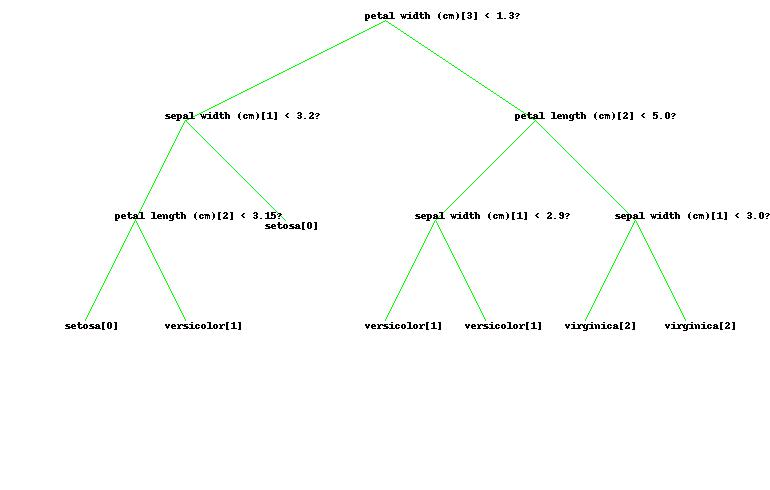

In [18]:
drawtree(DTree)